In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load datasets
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Merge datasets on 'CustomerID'
merged_df = pd.merge(customers_df, transactions_df, on='CustomerID', how='inner')

# Convert date columns to datetime
merged_df['SignupDate'] = pd.to_datetime(merged_df['SignupDate'])
merged_df['TransactionDate'] = pd.to_datetime(merged_df['TransactionDate'])

# Inspect the merged data
print(merged_df.head())


  CustomerID      CustomerName         Region SignupDate TransactionID  \
0      C0001  Lawrence Carroll  South America 2022-07-10        T00015   
1      C0001  Lawrence Carroll  South America 2022-07-10        T00932   
2      C0001  Lawrence Carroll  South America 2022-07-10        T00085   
3      C0001  Lawrence Carroll  South America 2022-07-10        T00445   
4      C0001  Lawrence Carroll  South America 2022-07-10        T00436   

  ProductID     TransactionDate  Quantity  TotalValue   Price  
0      P054 2024-01-19 03:12:55         2      114.60   57.30  
1      P022 2024-09-17 09:01:18         3      412.62  137.54  
2      P096 2024-04-08 00:01:00         2      614.94  307.47  
3      P083 2024-05-07 03:11:44         2      911.44  455.72  
4      P029 2024-11-02 17:04:16         3     1300.92  433.64  


In [4]:
from datetime import datetime

# Current date for recency calculation
current_date = datetime.now()

# Feature engineering
customer_metrics = merged_df.groupby('CustomerID').agg(
    TotalSpend=('TotalValue', 'sum'),
    TransactionCount=('TransactionID', 'count'),
    AverageSpend=('TotalValue', 'mean'),
    Recency=('TransactionDate', lambda x: (current_date - x.max()).days)
).reset_index()

# Merge customer profile data
final_df = pd.merge(customers_df[['CustomerID', 'Region']], customer_metrics, on='CustomerID', how='inner')

# Display the feature set
print(final_df.head())


  CustomerID         Region  TotalSpend  TransactionCount  AverageSpend  \
0      C0001  South America     3354.52                 5       670.904   
1      C0002           Asia     1862.74                 4       465.685   
2      C0003  South America     2725.38                 4       681.345   
3      C0004  South America     5354.88                 8       669.360   
4      C0005           Asia     2034.24                 3       678.080   

   Recency  
0       84  
1       54  
2      154  
3       34  
4       83  


In [6]:
# Normalize numerical features
scaler = StandardScaler()
numerical_features = ['TotalSpend', 'TransactionCount', 'AverageSpend', 'Recency']
scaled_features = scaler.fit_transform(final_df[numerical_features])

# One-hot encode the 'Region' feature
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_region = encoder.fit_transform(final_df[['Region']])

# Combine scaled numerical and encoded categorical features
final_features = np.hstack((scaled_features, encoded_region))


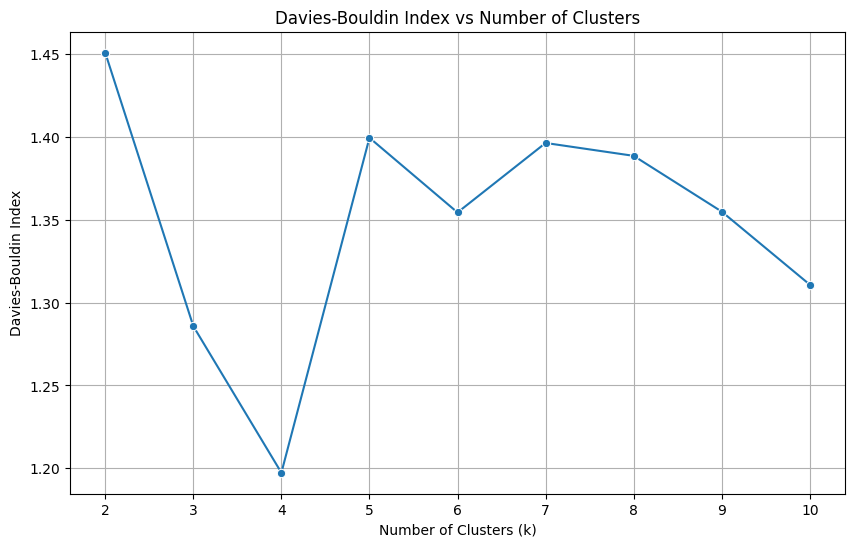

Optimal number of clusters: 4
Lowest DB Index: 1.19726707074186


In [7]:
db_scores = []
k_values = range(2, 11)
models = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(final_features)
    db_index = davies_bouldin_score(final_features, clusters)
    db_scores.append(db_index)
    models[k] = (kmeans, clusters)

# Plot DB Index vs Number of Clusters
plt.figure(figsize=(10, 6))
sns.lineplot(x=k_values, y=db_scores, marker='o')
plt.title("Davies-Bouldin Index vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Davies-Bouldin Index")
plt.xticks(k_values)
plt.grid()
plt.show()

# Print the optimal number of clusters and the DB Index
optimal_k = k_values[np.argmin(db_scores)]
print(f"Optimal number of clusters: {optimal_k}")
print(f"Lowest DB Index: {min(db_scores)}")


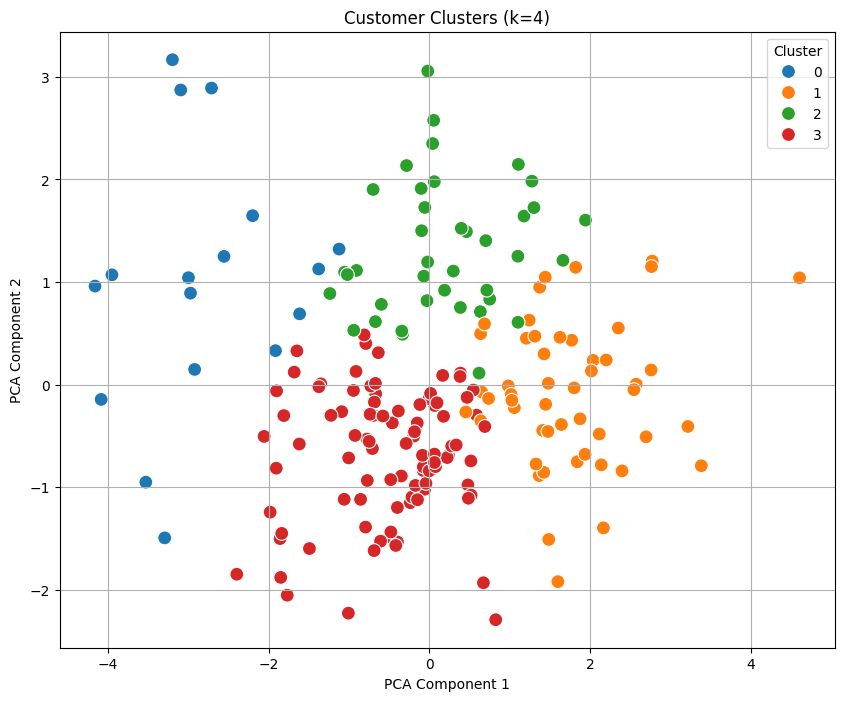

In [8]:
# Retrieve the optimal model and clusters
optimal_model, optimal_clusters = models[optimal_k]

# Reduce dimensionality with PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(final_features)

# Create a DataFrame for visualization
visualization_df = pd.DataFrame(reduced_features, columns=['PCA1', 'PCA2'])
visualization_df['Cluster'] = optimal_clusters

# Plot clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(data=visualization_df, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=100)
plt.title(f"Customer Clusters (k={optimal_k})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid()
plt.show()


In [10]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg = silhouette_score(final_features, optimal_clusters)
print(f"Silhouette Score for k={optimal_k}: {silhouette_avg}")


# Add cluster labels to the DataFrame
final_df['Cluster'] = optimal_clusters

# Cluster profiles
cluster_profiles = final_df.groupby('Cluster').agg(
    AvgSpend=('AverageSpend', 'mean'),
    TotalSpend=('TotalSpend', 'mean'),
    TransactionCount=('TransactionCount', 'mean'),
    Recency=('Recency', 'mean')
).reset_index()

print(cluster_profiles)

# Save the results
final_df.to_csv('Clustered_Customers.csv', index=False)
cluster_profiles.to_csv('Cluster_Profiles.csv', index=False)


Silhouette Score for k=4: 0.2611578913906147
   Cluster    AvgSpend   TotalSpend  TransactionCount     Recency
0        0  563.316716  1070.562353          1.764706  272.941176
1        1  756.915386  5748.162000          7.680000   74.560000
2        2  994.638363  3916.868718          3.974359  118.051282
3        3  544.251684  2490.645376          4.634409   81.107527


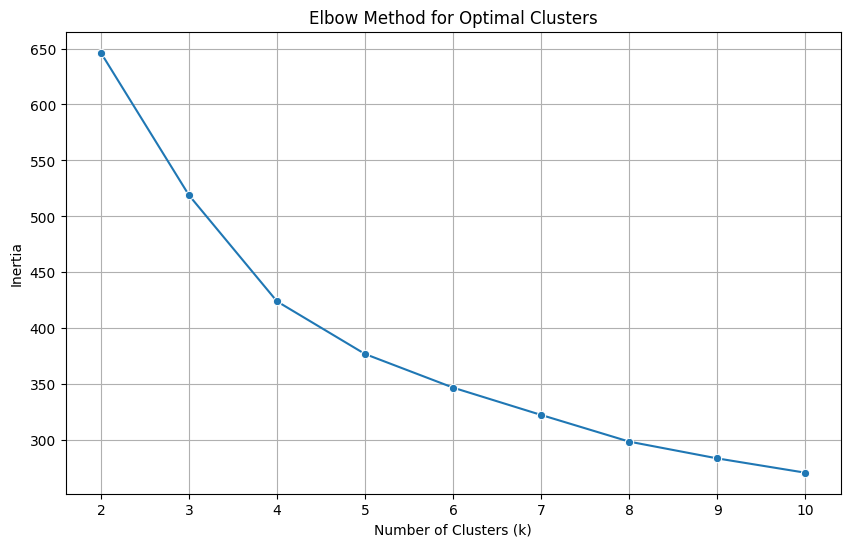

In [11]:
# Calculate inertia for the elbow method
inertia_values = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(final_features).inertia_ for k in range(2, 11)]

# Plot the elbow curve
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(2, 11), y=inertia_values, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid()
plt.show()
